In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
with open('../mfcc_loader/mfcc_dict.pickle', 'rb') as handle: 
        mfcc_dict = pickle.load(handle)

        
plt.pcolormesh(mfcc_dict[0][0])
plt.show()
plt.pcolormesh(mfcc_dict[0][1])
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [2]:
# """data preprocessing"""
# X = []
# y = []
# for it_0 in range(len(mfcc_dict)):
#     X_column = []
#     y_column = []
#     for it_1 in range(len(mfcc_dict[0])):
#         tmp = np.array(mfcc_dict[it_0][it_1])
#         tmp.resize((50, 13))
#         X_column.append(tmp)
#         y_column.append(it_1)
#     X.append(X_column)
#     y.append(y_column)
# X = np.array(X)
# y = np.array(y)

63.35909090909091
15.033089535811843
5


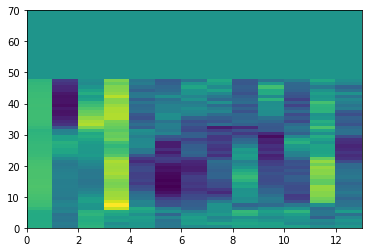

(22, 10, 70, 13)


In [2]:
"""data preprocessing"""
X = []
y = []
to_avg = []
for it_0 in range(len(mfcc_dict)):
    X_column = []
    y_column = []
    for it_1 in range(len(mfcc_dict[0])):
        tmp = np.array(mfcc_dict[it_0][it_1])
        to_avg.append(tmp.shape[0])
        if tmp.shape[0] > 70:
            tmp = tmp[:70, :]
        else:
            to_append = np.zeros((70 - tmp.shape[0], 13))
            tmp = np.concatenate((tmp, to_append), axis=0)
        X_column.append(tmp)
        y_column.append(it_1)
    X.append(X_column)
    y.append(y_column)
    
X = np.array(X)
y = np.array(y)
print(np.mean(to_avg))
print(np.std(to_avg))
print(y[10, 5])
plt.pcolormesh(X[10, 5])
plt.show()
print(X.shape)

In [4]:
# plt.pcolormesh(X[21, 5])
# print(y[21][5])

In [3]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.constraints import unit_norm
from keras.optimizers import Adam

input_shape = 70*13
print(input_shape)

"""MultiLayer Perceprton implementation"""

model_dense_input = Input(shape=(input_shape,))
model_dense = Dense(units=128, activation='relu', input_dim=input_shape,
             kernel_constraint=unit_norm())(model_dense_input)
model_dense = Dropout(0.5)(model_dense)
model_dense = Dense(units=128, activation='relu')(model_dense)
model_dense = Dense(units=64, activation='relu')(model_dense)
model_dense = Dense(units=10, activation='softmax')(model_dense)
model_dense = Model(inputs=model_dense_input, output=model_dense)

model_dense.summary()

adam = Adam(lr = 0.001)
model_dense.compile(loss='categorical_crossentropy',
             optimizer = adam, metrics=['accuracy'])
model_dense.save('model_dense_untrained.h5')

Using TensorFlow backend.
c:\users\wiktor\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\wiktor\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\wiktor\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

910
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 910)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               116608    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 142,026
Trainable params: 142,026
Non-trainable params: 0
_________________________________________________

W1115 17:34:14.931412  4844 deprecation_wrapper.py:119] From c:\users\wiktor\appdata\local\programs\python\python36\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1115 17:34:14.948402  4844 deprecation_wrapper.py:119] From c:\users\wiktor\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



In [4]:
"""implementing Convolutional Neural Network"""

model_conv_input = Input(shape=(X.shape[2], 
                                X.shape[3],
                                1))
model_conv = Conv2D(filters=8, kernel_size=(5,5), strides=(8,8),
                    padding='same', activation='sigmoid')(model_conv_input)
# model_conv = Conv2D(filters=16, kernel_size=(5,5), strides=(4,4),
#                     padding='same', activation='sigmoid')(model_conv)
model_conv = Flatten()(model_conv)
model_conv = Dense(units=100, activation='sigmoid')(model_conv)
# model_conv = Dense(units=128, activation='sigmoid')(model_conv)
model_conv = Dense(units=10, activation='softmax')(model_conv)
model_conv = Model(inputs=model_conv_input, output=model_conv)

model_conv.summary()

adam = Adam(lr = 0.001)
model_conv.compile(loss='categorical_crossentropy',
              optimizer = adam, metrics=['accuracy'])

model_conv.save('model_conv_untrained.h5')

c:\users\wiktor\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 70, 13, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 2, 8)           208       
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               14500     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 15,718
Trainable params: 15,718
Non-trainable params: 0
_________________________________________________________________


In [40]:
from sklearn.model_selection import KFold
from keras.models import load_model
from keras.utils import to_categorical
from tqdm import tqdm
x_valid = KFold(n_splits=5)
acc_vector = []
for train_idxs, test_idxs in tqdm(x_valid.split(X)):
#     """loading untrained model"""
    model = load_model('model_conv_untrained.h5')
    """importing data"""
    X_train = X[train_idxs, :]
    X_test = X[test_idxs, :]
    y_train = y[train_idxs, :]
    y_test = y[test_idxs, :]
    """reshaping to 2d tensor 
        axis0 - n0 of data example
        axis1 - mfcc flatten to feed into FNN"""
    X_train_flat = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 70*13))
    X_train_conv = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 70, 13, 1))
    y_train = np.reshape(y_train, (y_train.shape[0]*y_train.shape[1]))
    y_train_onehot = to_categorical(y_train, 10)
    X_test_flat = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], 70*13))
    X_test_conv = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], 70, 13, 1))
    y_test = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1]))    
    y_test_onehot = to_categorical(y_test, 10)
    
    model_conv.fit(X_train_conv, y_train_onehot, epochs=20, steps_per_epoch=100, 
          validation_data=(X_test_conv, y_test_onehot), validation_steps=1)
    score, acc = model_conv.evaluate(X_test_conv, y_test_onehot, batch_size=10)
    acc_vector.append(acc)


0it [00:00, ?it/s]

Train on 170 samples, validate on 50 samples
Epoch 1/20
100/100 [==============================] - ETA: 4:47 - loss: 2.5510 - acc: 0.100 - ETA: 46s - loss: 2.4038 - acc: 0.118 - ETA: 24s - loss: 2.3180 - acc: 0.17 - ETA: 18s - loss: 2.2806 - acc: 0.22 - ETA: 16s - loss: 2.2582 - acc: 0.26 - ETA: 11s - loss: 2.2051 - acc: 0.32 - ETA: 9s - loss: 2.1629 - acc: 0.3741 - ETA: 8s - loss: 2.1310 - acc: 0.416 - ETA: 7s - loss: 2.0989 - acc: 0.459 - ETA: 6s - loss: 2.0667 - acc: 0.495 - ETA: 5s - loss: 2.0234 - acc: 0.535 - ETA: 5s - loss: 1.9907 - acc: 0.561 - ETA: 4s - loss: 1.9467 - acc: 0.592 - ETA: 3s - loss: 1.9026 - acc: 0.618 - ETA: 3s - loss: 1.8696 - acc: 0.635 - ETA: 2s - loss: 1.8258 - acc: 0.655 - ETA: 2s - loss: 1.7824 - acc: 0.673 - ETA: 2s - loss: 1.7395 - acc: 0.689 - ETA: 1s - loss: 1.6870 - acc: 0.707 - ETA: 1s - loss: 1.6257 - acc: 0.725 - ETA: 1s - loss: 1.5764 - acc: 0.739 - ETA: 0s - loss: 1.5103 - acc: 0.756 - ETA: 0s - loss: 1.4740 - acc: 0.765 - ETA: 0s - loss: 1.4219 

100/100 [==============================] - ETA: 1s - loss: 0.0017 - acc: 1.000 - ETA: 1s - loss: 0.0017 - acc: 1.000 - ETA: 1s - loss: 0.0017 - acc: 1.000 - ETA: 1s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - 1s 12ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3926 - val_acc: 0.8400
Epoch 18/20
100/100 [==============================] - ETA: 1s - loss: 0.0015 - 


1it [00:30, 30.05s/it]

Train on 170 samples, validate on 50 samples
Epoch 1/20
100/100 [==============================] - ETA: 3:40 - loss: 0.1186 - acc: 0.952 - ETA: 30s - loss: 0.0628 - acc: 0.980 - ETA: 15s - loss: 0.0470 - acc: 0.98 - ETA: 10s - loss: 0.0365 - acc: 0.99 - ETA: 7s - loss: 0.0302 - acc: 0.9946 - ETA: 5s - loss: 0.0264 - acc: 0.995 - ETA: 5s - loss: 0.0241 - acc: 0.996 - ETA: 4s - loss: 0.0222 - acc: 0.996 - ETA: 3s - loss: 0.0199 - acc: 0.996 - ETA: 2s - loss: 0.0180 - acc: 0.997 - ETA: 2s - loss: 0.0168 - acc: 0.997 - ETA: 1s - loss: 0.0156 - acc: 0.997 - ETA: 1s - loss: 0.0147 - acc: 0.998 - ETA: 1s - loss: 0.0139 - acc: 0.998 - ETA: 0s - loss: 0.0132 - acc: 0.998 - ETA: 0s - loss: 0.0127 - acc: 0.998 - ETA: 0s - loss: 0.0123 - acc: 0.998 - ETA: 0s - loss: 0.0117 - acc: 0.998 - ETA: 0s - loss: 0.0113 - acc: 0.998 - 3s 33ms/step - loss: 0.0108 - acc: 0.9986 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 2/20
100/100 [==============================] - ETA: 1s - loss: 0.0031 - acc: 1.000 - ETA:

100/100 [==============================] - ETA: 0s - loss: 3.2092e-04 - acc: 1.000 - ETA: 1s - loss: 3.2025e-04 - acc: 1.000 - ETA: 1s - loss: 3.1971e-04 - acc: 1.000 - ETA: 1s - loss: 3.1917e-04 - acc: 1.000 - ETA: 0s - loss: 3.1838e-04 - acc: 1.000 - ETA: 0s - loss: 3.1758e-04 - acc: 1.000 - ETA: 0s - loss: 3.1705e-04 - acc: 1.000 - ETA: 0s - loss: 3.1639e-04 - acc: 1.000 - ETA: 0s - loss: 3.1574e-04 - acc: 1.000 - ETA: 0s - loss: 3.1509e-04 - acc: 1.000 - ETA: 0s - loss: 3.1444e-04 - acc: 1.000 - ETA: 0s - loss: 3.1392e-04 - acc: 1.000 - ETA: 0s - loss: 3.1314e-04 - acc: 1.000 - ETA: 0s - loss: 3.1263e-04 - acc: 1.000 - ETA: 0s - loss: 3.1173e-04 - acc: 1.000 - ETA: 0s - loss: 3.1109e-04 - acc: 1.000 - ETA: 0s - loss: 3.1046e-04 - acc: 1.000 - ETA: 0s - loss: 3.0957e-04 - acc: 1.000 - ETA: 0s - loss: 3.0919e-04 - acc: 1.000 - ETA: 0s - loss: 3.0844e-04 - acc: 1.000 - 1s 11ms/step - loss: 3.0806e-04 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 18/20
100/100 [=============


2it [00:57, 29.28s/it]

Train on 180 samples, validate on 40 samples
Epoch 1/20
100/100 [==============================] - ETA: 3:18 - loss: 0.0013 - acc: 1.000 - ETA: 32s - loss: 9.9171e-04 - acc: 1.00 - ETA: 15s - loss: 7.7399e-04 - acc: 1.00 - ETA: 11s - loss: 7.0504e-04 - acc: 1.00 - ETA: 7s - loss: 6.4819e-04 - acc: 1.0000 - ETA: 6s - loss: 6.1762e-04 - acc: 1.000 - ETA: 5s - loss: 5.9739e-04 - acc: 1.000 - ETA: 4s - loss: 5.7524e-04 - acc: 1.000 - ETA: 3s - loss: 5.5598e-04 - acc: 1.000 - ETA: 3s - loss: 5.4250e-04 - acc: 1.000 - ETA: 2s - loss: 5.3341e-04 - acc: 1.000 - ETA: 2s - loss: 5.2250e-04 - acc: 1.000 - ETA: 2s - loss: 5.1276e-04 - acc: 1.000 - ETA: 1s - loss: 5.0401e-04 - acc: 1.000 - ETA: 1s - loss: 4.9608e-04 - acc: 1.000 - ETA: 1s - loss: 4.8710e-04 - acc: 1.000 - ETA: 1s - loss: 4.8056e-04 - acc: 1.000 - ETA: 0s - loss: 4.7450e-04 - acc: 1.000 - ETA: 0s - loss: 4.6887e-04 - acc: 1.000 - ETA: 0s - loss: 4.6361e-04 - acc: 1.000 - ETA: 0s - loss: 4.5867e-04 - acc: 1.000 - ETA: 0s - loss: 4.55

100/100 [==============================] - ETA: 1s - loss: 1.0064e-04 - acc: 1.000 - ETA: 1s - loss: 1.0050e-04 - acc: 1.000 - ETA: 1s - loss: 1.0037e-04 - acc: 1.000 - ETA: 1s - loss: 1.0023e-04 - acc: 1.000 - ETA: 1s - loss: 1.0009e-04 - acc: 1.000 - ETA: 0s - loss: 9.9922e-05 - acc: 1.000 - ETA: 0s - loss: 9.9752e-05 - acc: 1.000 - ETA: 0s - loss: 9.9583e-05 - acc: 1.000 - ETA: 0s - loss: 9.9415e-05 - acc: 1.000 - ETA: 0s - loss: 9.9314e-05 - acc: 1.000 - ETA: 0s - loss: 9.9180e-05 - acc: 1.000 - ETA: 0s - loss: 9.9013e-05 - acc: 1.000 - ETA: 0s - loss: 9.8846e-05 - acc: 1.000 - ETA: 0s - loss: 9.8680e-05 - acc: 1.000 - ETA: 0s - loss: 9.8514e-05 - acc: 1.000 - ETA: 0s - loss: 9.8349e-05 - acc: 1.000 - ETA: 0s - loss: 9.8217e-05 - acc: 1.000 - ETA: 0s - loss: 9.8052e-05 - acc: 1.000 - ETA: 0s - loss: 9.7888e-05 - acc: 1.000 - ETA: 0s - loss: 9.7757e-05 - acc: 1.000 - ETA: 0s - loss: 9.7594e-05 - acc: 1.000 - ETA: 0s - loss: 9.7464e-05 - acc: 1.000 - 1s 13ms/step - loss: 9.7334e-05 -


3it [01:30, 30.28s/it]

Train on 180 samples, validate on 40 samples
Epoch 1/20
100/100 [==============================] - ETA: 3:56 - loss: 8.7746e-05 - acc: 1.000 - ETA: 46s - loss: 8.7542e-05 - acc: 1.000 - ETA: 25s - loss: 8.7222e-05 - acc: 1.00 - ETA: 15s - loss: 8.6739e-05 - acc: 1.00 - ETA: 11s - loss: 8.6221e-05 - acc: 1.00 - ETA: 8s - loss: 8.5810e-05 - acc: 1.0000 - ETA: 6s - loss: 8.5224e-05 - acc: 1.000 - ETA: 5s - loss: 8.4857e-05 - acc: 1.000 - ETA: 4s - loss: 8.4427e-05 - acc: 1.000 - ETA: 3s - loss: 8.4026e-05 - acc: 1.000 - ETA: 3s - loss: 8.3651e-05 - acc: 1.000 - ETA: 2s - loss: 8.3297e-05 - acc: 1.000 - ETA: 2s - loss: 8.3028e-05 - acc: 1.000 - ETA: 1s - loss: 8.2706e-05 - acc: 1.000 - ETA: 1s - loss: 8.2460e-05 - acc: 1.000 - ETA: 1s - loss: 8.2163e-05 - acc: 1.000 - ETA: 1s - loss: 8.1878e-05 - acc: 1.000 - ETA: 0s - loss: 8.1712e-05 - acc: 1.000 - ETA: 0s - loss: 8.1444e-05 - acc: 1.000 - ETA: 0s - loss: 8.1133e-05 - acc: 1.000 - ETA: 0s - loss: 8.0882e-05 - acc: 1.000 - ETA: 0s - loss:

100/100 [==============================] - ETA: 1s - loss: 3.3409e-05 - acc: 1.000 - ETA: 1s - loss: 3.3359e-05 - acc: 1.000 - ETA: 1s - loss: 3.3302e-05 - acc: 1.000 - ETA: 0s - loss: 3.3251e-05 - acc: 1.000 - ETA: 0s - loss: 3.3201e-05 - acc: 1.000 - ETA: 0s - loss: 3.3150e-05 - acc: 1.000 - ETA: 0s - loss: 3.3121e-05 - acc: 1.000 - ETA: 0s - loss: 3.3080e-05 - acc: 1.000 - ETA: 0s - loss: 3.3031e-05 - acc: 1.000 - ETA: 0s - loss: 3.2971e-05 - acc: 1.000 - ETA: 0s - loss: 3.2922e-05 - acc: 1.000 - ETA: 0s - loss: 3.2873e-05 - acc: 1.000 - ETA: 0s - loss: 3.2824e-05 - acc: 1.000 - ETA: 0s - loss: 3.2765e-05 - acc: 1.000 - ETA: 0s - loss: 3.2716e-05 - acc: 1.000 - ETA: 0s - loss: 3.2658e-05 - acc: 1.000 - ETA: 0s - loss: 3.2619e-05 - acc: 1.000 - ETA: 0s - loss: 3.2560e-05 - acc: 1.000 - ETA: 0s - loss: 3.2512e-05 - acc: 1.000 - ETA: 0s - loss: 3.2463e-05 - acc: 1.000 - 1s 12ms/step - loss: 3.2434e-05 - acc: 1.0000 - val_loss: 3.2370e-05 - val_acc: 1.0000
Epoch 15/20
100/100 [=========


4it [02:02, 30.97s/it]

Train on 180 samples, validate on 40 samples
Epoch 1/20
100/100 [==============================] - ETA: 3:21 - loss: 2.3954e-05 - acc: 1.000 - ETA: 32s - loss: 2.3870e-05 - acc: 1.000 - ETA: 17s - loss: 2.3740e-05 - acc: 1.00 - ETA: 10s - loss: 2.3566e-05 - acc: 1.00 - ETA: 7s - loss: 2.3400e-05 - acc: 1.0000 - ETA: 5s - loss: 2.3250e-05 - acc: 1.000 - ETA: 4s - loss: 2.3117e-05 - acc: 1.000 - ETA: 3s - loss: 2.2997e-05 - acc: 1.000 - ETA: 2s - loss: 2.2889e-05 - acc: 1.000 - ETA: 2s - loss: 2.2789e-05 - acc: 1.000 - ETA: 1s - loss: 2.2710e-05 - acc: 1.000 - ETA: 1s - loss: 2.2636e-05 - acc: 1.000 - ETA: 1s - loss: 2.2552e-05 - acc: 1.000 - ETA: 0s - loss: 2.2484e-05 - acc: 1.000 - ETA: 0s - loss: 2.2419e-05 - acc: 1.000 - ETA: 0s - loss: 2.2344e-05 - acc: 1.000 - ETA: 0s - loss: 2.2284e-05 - acc: 1.000 - ETA: 0s - loss: 2.2214e-05 - acc: 1.000 - 3s 31ms/step - loss: 2.2168e-05 - acc: 1.0000 - val_loss: 2.2588e-05 - val_acc: 1.0000
Epoch 2/20
100/100 [==============================] - 

100/100 [==============================] - ETA: 0s - loss: 8.4510e-06 - acc: 1.000 - ETA: 1s - loss: 8.4375e-06 - acc: 1.000 - ETA: 1s - loss: 8.4268e-06 - acc: 1.000 - ETA: 1s - loss: 8.4126e-06 - acc: 1.000 - ETA: 1s - loss: 8.4024e-06 - acc: 1.000 - ETA: 0s - loss: 8.3904e-06 - acc: 1.000 - ETA: 0s - loss: 8.3785e-06 - acc: 1.000 - ETA: 0s - loss: 8.3644e-06 - acc: 1.000 - ETA: 0s - loss: 8.3528e-06 - acc: 1.000 - ETA: 0s - loss: 8.3411e-06 - acc: 1.000 - ETA: 0s - loss: 8.3296e-06 - acc: 1.000 - ETA: 0s - loss: 8.3181e-06 - acc: 1.000 - ETA: 0s - loss: 8.3065e-06 - acc: 1.000 - ETA: 0s - loss: 8.2929e-06 - acc: 1.000 - ETA: 0s - loss: 8.2817e-06 - acc: 1.000 - ETA: 0s - loss: 8.2683e-06 - acc: 1.000 - ETA: 0s - loss: 8.2572e-06 - acc: 1.000 - ETA: 0s - loss: 8.2461e-06 - acc: 1.000 - ETA: 0s - loss: 8.2327e-06 - acc: 1.000 - ETA: 0s - loss: 8.2213e-06 - acc: 1.000 - 1s 12ms/step - loss: 8.2168e-06 - acc: 1.0000 - val_loss: 2.5522e-05 - val_acc: 1.0000
Epoch 18/20
100/100 [=========


5it [02:31, 30.40s/it]

Train on 170 samples, validate on 50 samples
Epoch 1/20
170/170 [==============================] - 1s 6ms/step - loss: 10.6571 - acc: 0.1529 - val_loss: 6.9131 - val_acc: 0.2800
Epoch 2/20
170/170 [==============================] - 0s 329us/step - loss: 7.8740 - acc: 0.2471 - val_loss: 2.6109 - val_acc: 0.5000
Epoch 3/20
170/170 [==============================] - 0s 347us/step - loss: 4.4782 - acc: 0.4059 - val_loss: 1.7522 - val_acc: 0.6200
Epoch 4/20
170/170 [==============================] - 0s 376us/step - loss: 3.3647 - acc: 0.4824 - val_loss: 1.0833 - val_acc: 0.6800
Epoch 5/20
170/170 [==============================] - 0s 370us/step - loss: 2.3628 - acc: 0.5765 - val_loss: 0.9787 - val_acc: 0.7800
Epoch 6/20
170/170 [==============================] - 0s 341us/step - loss: 1.9775 - acc: 0.6529 - val_loss: 0.7590 - val_acc: 0.8000
Epoch 7/20
170/170 [==============================] - 0s 359us/step - loss: 1.9260 - acc: 0.6118 - val_loss: 0.5530 - val_acc: 0.7800
Epoch 8/20
170/170

Epoch 20/20
40/40 [==============================] - 0s 225us/step
Train on 180 samples, validate on 40 samples
Epoch 1/20
180/180 [==============================] - 1s 8ms/step - loss: 11.0218 - acc: 0.1222 - val_loss: 5.7810 - val_acc: 0.2000
Epoch 2/20
180/180 [==============================] - 0s 489us/step - loss: 6.9780 - acc: 0.3167 - val_loss: 2.4914 - val_acc: 0.5000
Epoch 3/20
180/180 [==============================] - 0s 355us/step - loss: 4.3862 - acc: 0.4167 - val_loss: 1.1213 - val_acc: 0.7750
Epoch 4/20
180/180 [==============================] - 0s 499us/step - loss: 2.7392 - acc: 0.5389 - val_loss: 0.4701 - val_acc: 0.8250
Epoch 5/20
180/180 [==============================] - 0s 339us/step - loss: 2.0628 - acc: 0.5833 - val_loss: 0.1803 - val_acc: 0.9000
Epoch 6/20
180/180 [==============================] - 0s 333us/step - loss: 1.1905 - acc: 0.7389 - val_loss: 0.2671 - val_acc: 0.9250
Epoch 7/20
180/180 [==============================] - 0s 344us/step - loss: 1.1933 - 

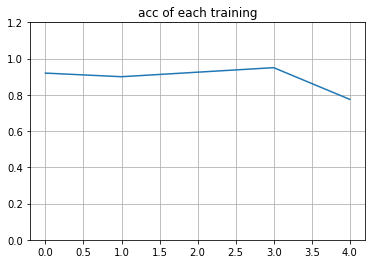

In [6]:
from utils import train_and_validate

models = train_and_validate(X, y, model_type='dense', epochs=20)

In [17]:
print(X_test_flat.shape, y_test_onehot.shape)

(40, 910) (40, 10)


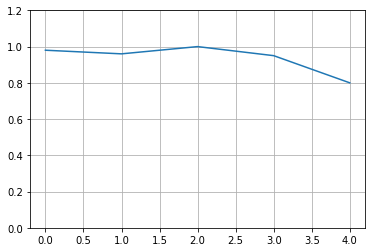

avg acc:  0.937999997138977
std dev:  0.07110554915555009


In [20]:
plt.plot(acc_vector)
plt.ylim(0,1.2)
plt.grid()
plt.show()
print('avg acc: ', np.mean(acc_vector))
print('std dev: ', np.std(acc_vector))